# Comparative Analysis of Word Difficulty Metrics for Language Learning

## Project Overview

This notebook implements a comprehensive language learning tool designed to assist language learners through intelligent text analysis. The project has three primary objectives:

1. **Topic-based Sentence Grouping**: Extract sentences from subtitle files (.srt) and automatically group them by semantic topics using BERTopic clustering

2. **Dual Word Difficulty Analysis**: Implement and compare two distinct computational approaches for determining word difficulty:
   - **Method A: Word Frequency** - A classic and robust approach where word frequency in large corpora serves as a proxy for difficulty (common words = easier)
   - **Method B: Embedding L2 Norm** - An experimental approach that leverages the L2 norm of word embeddings as a difficulty indicator based on the hypothesis that training frequency correlates with embedding magnitude

3. **Comparative Visualization**: Present a side-by-side comparison of both methods through color-coded visualizations, enabling qualitative and quantitative analysis of their effectiveness

This notebook serves as a small academic experiment to evaluate which computational method provides more intuitive and useful difficulty assessments for language learning applications.

### ⚠️ A Note on Performance & Scalability

This notebook is designed as a comprehensive academic demonstration and performs all data processing from scratch. Please be aware of the following:

* **Lexicon Generation is Slow:** The initial creation of the word frequency lexicon (Method A) and the embedding norm lexicon (Method B) is computationally intensive. The process involves downloading and processing a large text corpus, which can take a significant amount of time (potentially 10-20 minutes or more, depending on your connection and CPU).

* **One-Time Cost:** This heavy computation is a one-time setup cost for each language. In a real-world application, these generated lexicons would be saved to a file (`.json` or `.csv`) and simply loaded in future sessions, making the tool run instantly for the end-user.

For this demonstration, the script has a built-in limit to process a smaller subset of the corpus to ensure it runs in a reasonable time.

## 1. Setup and Configuration

In [1]:
# Install Dependencies
# Installing all required libraries with quiet output using %pip for local environment
%pip install -q bertopic datasets pandas numpy nltk pysrt sentence-transformers torch ipywidgets matplotlib seaborn spacy

# Download the spaCy model for the default target language
# Replace 'es_core_news_sm' if you change the default TARGET_LANGUAGE above
%pip install https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---- ----------------------------------- 1.6/12.9 MB 8.8 MB/s eta 0:00:02
     ---------- ----------------------------- 3.4/12.9 MB 9.0 MB/s eta 0:00:02
     ---------------- ----------------------- 5.2/12.9 MB 8.9 MB/s eta 0:00:01
     --------------------- ------------------ 7.1/12.9 MB 8.9 MB/s eta 0:00:01
     --------------------------- ------------ 8.9/12.9 MB 8.9 MB/s eta 0:00:01
     -------------------------------- ------- 10.5/12.9 MB 8.9 MB/s eta 0:00:01
     ---------------------------------------  12.6/12.9 MB 8.9 MB/s eta 0:00:01
     ---------------------------------------- 12.9/12.9 MB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Core Libraries
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Modelling
import nltk
from nltk.stem import WordNetLemmatizer
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
import spacy

# File Handling & Display
import pysrt
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

print("All libraries imported successfully!")

[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\omar\AppData\Roaming\nltk_data...


All libraries imported successfully!


[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
# Simple spaCy model verification and installation
import sys
import subprocess

def check_and_install_spacy_model():
    """Simple and robust spaCy model verification"""
    try:
        import spacy
        print("✅ spaCy is available")

        # Try to load the model
        try:
            nlp_test = spacy.load("es_core_news_sm")
            print("✅ Spanish model 'es_core_news_sm' is already available and working")
            return True
        except OSError:
            print("⚠️ Spanish model not found, attempting installation...")

        # Simple installation approach
        try:
            print("📦 Installing Spanish model...")
            result = subprocess.run([
                sys.executable, "-m", "pip", "install", "--quiet",
                "https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl"
            ], check=True, capture_output=True, text=True, timeout=300)

            # Test the installation
            nlp_test = spacy.load("es_core_news_sm")
            print("✅ Spanish model installed and verified successfully")
            return True

        except Exception as e:
            print(f"⚠️ Installation failed: {str(e)[:100]}")
            print("🔄 System will continue with basic lemmatization fallback")
            return False

    except ImportError:
        print("❌ spaCy not available")
        return False

# Run the installation check
spacy_available = check_and_install_spacy_model()
print(f"\nFinal status: {'✅ spaCy model ready' if spacy_available else '⚠️ Using fallback mode'}")

✅ spaCy is available
✅ Spanish model 'es_core_news_sm' is already available and working

Final status: ✅ spaCy model ready
✅ Spanish model 'es_core_news_sm' is already available and working

Final status: ✅ spaCy model ready


In [4]:
# --- USER CONFIGURATION ---

# Set the target language using ISO 639-1 code ('es' for Spanish, 'pt' for Portuguese, 'fr' for French, 'de' for German)
TARGET_LANGUAGE = "es"

# Path to the input subtitle file. Create a placeholder file or ask the user to provide one.
SRT_FILE_PATH = "sample_subtitles.srt"

# Path to the English CEFR words CSV file
CEFR_CSV_PATH = "ENGLISH_CERF_WORDS.csv"

# Model for multilingual embeddings. This is a good, lightweight choice.
MULTILINGUAL_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"

# --- DIFFICULTY TIER DEFINITIONS ---
# Method A (Frequency): Tiers based on rank of most common words.
FREQUENCY_TIERS = {
    'A1': (0, 1000),      # Top 1000 words
    'A2': (1000, 4000),   # Next 3000
    'B1': (4000, 10000),  # Next 6000
    'B2': (10000, 20000), # Next 10000
    'C1': (20000, 40000), # And so on...
    'C2': (40000, float('inf'))
}

# Method B (Embedding Norm): Tiers based on percentile of normalized L2 Norm.
NORM_TIERS = {
    'A1': (0.8, 1.0),     # Top 20% of norms (most frequent-like)
    'A2': (0.6, 0.8),     # 60th-80th percentile
    'B1': (0.4, 0.6),
    'B2': (0.2, 0.4),
    'C1': (0.1, 0.2),
    'C2': (0.0, 0.1)      # Bottom 10% (rarest-like)
}

# --- VISUALS ---
COLOR_MAP = {
    'A1': '#4CAF50',  # Green
    'A2': '#8BC34A',  # Light Green
    'B1': '#FFC107',  # Amber
    'B2': '#FF9800',  # Orange
    'C1': '#F44336',  # Red
    'C2': '#B71C1C',  # Dark Red
    'OOV': '#607D8B'  # Blue Grey (Out of Vocabulary)
}

print(f"Configuration set for language: {TARGET_LANGUAGE}")
print(f"Using model: {MULTILINGUAL_MODEL}")
print(f"Color scheme: {list(COLOR_MAP.keys())}")

Configuration set for language: es
Using model: paraphrase-multilingual-MiniLM-L12-v2
Color scheme: ['A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'OOV']


In [5]:
# --- Load spaCy Model for Lemmatisation ---

# A mapping from our language codes to spaCy's model names
LANG_TO_SPACY_MODEL = {
    "es": "es_core_news_sm",  # Spanish
    "pt": "pt_core_news_sm",  # Portuguese
    "fr": "fr_core_news_sm",  # French
    "de": "de_core_news_sm",  # German
    "en": "en_core_web_sm"   # English
}

print(f"Loading spaCy model for language: '{TARGET_LANGUAGE}'")
model_name = LANG_TO_SPACY_MODEL.get(TARGET_LANGUAGE)

if model_name:
    try:
        nlp = spacy.load(model_name)
        print(f"Successfully loaded '{model_name}'")
    except OSError:
        print(f"🛑 spaCy model '{model_name}' not found.")
        print(f"Please run: !python -m spacy download {model_name}")
        nlp = None
else:
    print(f"⚠️ No spaCy model defined for '{TARGET_LANGUAGE}'. Lemmatisation will be skipped.")
    nlp = None

Loading spaCy model for language: 'es'
Successfully loaded 'es_core_news_sm'
Successfully loaded 'es_core_news_sm'


## 2. Data Loading & Preprocessing

This section handles the parsing of subtitle files (.srt) to extract clean, meaningful sentences for analysis. We'll use the `pysrt` library to parse the subtitle format and clean the extracted text to prepare it for topic modeling and difficulty analysis.

In [6]:
def parse_srt(file_path):
    """
    Parse an SRT subtitle file and extract clean sentences.

    Args:
        file_path (str): Path to the SRT file

    Returns:
        list: List of cleaned sentences
    """
    try:
        # Load the SRT file
        subs = pysrt.open(file_path)
        sentences = []

        for sub in subs:
            # Get the text content and clean it
            text = sub.text
            if text:
                # Remove HTML tags if any
                text = re.sub(r'<[^>]+>', '', text)
                # Remove excessive whitespace and newlines
                text = re.sub(r'\s+', ' ', text).strip()
                # Only add non-empty sentences
                if text and len(text) > 3:
                    sentences.append(text)

        return sentences

    except FileNotFoundError:
        print(f"Error: Could not find the file '{file_path}'")
        print("Creating a sample dataset for demonstration...")

        # Create sample sentences in Spanish for demonstration
        sample_sentences = [
            "Hola, ¿cómo estás hoy?",
            "Me gusta mucho la comida española.",
            "El clima está muy agradable esta mañana.",
            "Vamos al parque para caminar un poco.",
            "La tecnología ha cambiado nuestras vidas completamente.",
            "Los estudiantes están preparando sus exámenes finales.",
            "El museo de arte moderno tiene una exposición interesante.",
            "Mi familia viene a visitarme este fin de semana.",
            "La economía global enfrenta muchos desafíos actualmente.",
            "Los científicos han descubierto nuevas especies marinas.",
            "La música clásica me ayuda a relajarme por las noches.",
            "El transporte público es muy eficiente en esta ciudad.",
            "Los libros de historia siempre me han fascinado mucho.",
            "La naturaleza nos enseña lecciones importantes sobre la vida.",
            "El desarrollo sostenible es crucial para el futuro del planeta."
        ]
        return sample_sentences

    except Exception as e:
        print(f"Error parsing SRT file: {str(e)}")
        return []

# Load sentences from the SRT file
sentences = parse_srt(SRT_FILE_PATH)

print(f"Total sentences found: {len(sentences)}")
print("\nFirst 5 sentences:")
for i, sentence in enumerate(sentences[:5], 1):
    print(f"{i}. {sentence}")

Total sentences found: 15

First 5 sentences:
1. Hola, ¿cómo estás hoy?
2. Me gusta mucho la comida española.
3. El clima está muy agradable esta mañana.
4. Vamos al parque para caminar un poco.
5. La tecnología ha cambiado nuestras vidas completamente.


## 3. Method A: Word Frequency Lexicon

This method implements the classical approach to word difficulty assessment based on frequency analysis. The underlying theory is straightforward: words that appear more frequently in large text corpora are generally easier for language learners to understand and use.

**Process:**
1. Download a large corpus for the target language using the OPUS Books dataset
2. Calculate word frequencies across the entire corpus
3. Rank words by frequency (most frequent = rank 1)
4. Map frequency ranks to CEFR-like difficulty tiers (A1, A2, B1, B2, C1, C2)

This approach has been validated in numerous linguistic studies and forms the basis for many language learning applications.

In [7]:
def calculate_frequency_lexicon(language_code, tiers):
    """
    Calculate word difficulty based on frequency analysis of large corpora.

    Args:
        language_code (str): ISO 639-1 language code
        tiers (dict): Dictionary mapping CEFR levels to rank ranges

    Returns:
        dict: Dictionary mapping words to CEFR difficulty levels
    """
    print(f"Calculating frequency lexicon for language: {language_code}")

    try:
        # Load the OPUS Books dataset for the target language
        print("Loading OPUS Books dataset...")
        dataset = load_dataset("opus_books", f"en-{language_code}", streaming=True, split="train")

        word_counter = Counter()
        processed_count = 0

        # Process the dataset
        for example in dataset:
            # Get text from the target language
            text = example['translation'][language_code]
            if text:
                # Preprocess: lowercase and extract words
                text = text.lower()
                words = re.findall(r'\b[a-záéíóúñü]+\b', text)  # Include Spanish characters
                word_counter.update(words)

                processed_count += 1
                if processed_count % 1000 == 0:
                    print(f"Processed {processed_count} examples...")

                # Limit processing for demonstration (remove in production)
                if processed_count >= 5000:
                    break

        print(f"Total unique words found: {len(word_counter)}")

        # Create sorted list of most common words
        most_common = word_counter.most_common()

        # Create the lexicon dictionary
        lexicon = {}
        for rank, (word, count) in enumerate(most_common):
            # Determine tier based on rank
            tier = 'C2'  # Default to most difficult
            for level, (min_rank, max_rank) in tiers.items():
                if min_rank <= rank < max_rank:
                    tier = level
                    break
            lexicon[word] = tier

        return lexicon

    except Exception as e:
        print(f"Error loading dataset: {str(e)}")
        print("Creating sample frequency lexicon...")

        # Create a sample lexicon for demonstration
        sample_lexicon = {
            # A1 - Most common words
            'el': 'A1', 'la': 'A1', 'de': 'A1', 'que': 'A1', 'y': 'A1',
            'a': 'A1', 'en': 'A1', 'un': 'A1', 'es': 'A1', 'se': 'A1',
            'no': 'A1', 'te': 'A1', 'lo': 'A1', 'le': 'A1', 'da': 'A1',
            'su': 'A1', 'por': 'A1', 'son': 'A1', 'con': 'A1', 'para': 'A1',
            'como': 'A1', 'está': 'A1', 'hola': 'A1', 'muy': 'A1',

            # A2 - Common words
            'gusta': 'A2', 'comida': 'A2', 'familia': 'A2', 'casa': 'A2',
            'trabajo': 'A2', 'tiempo': 'A2', 'música': 'A2', 'libro': 'A2',
            'ciudad': 'A2', 'amigo': 'A2', 'español': 'A2', 'año': 'A2',

            # B1 - Intermediate words
            'tecnología': 'B1', 'estudiantes': 'B1', 'universidad': 'B1',
            'gobierno': 'B1', 'problema': 'B1', 'sociedad': 'B1',
            'cultural': 'B1', 'historia': 'B1', 'educación': 'B1',

            # B2 - Upper intermediate
            'economía': 'B2', 'científicos': 'B2', 'exposición': 'B2',
            'desarrollo': 'B2', 'investigación': 'B2', 'comunicación': 'B2',

            # C1 - Advanced
            'sostenible': 'C1', 'implementación': 'C1', 'metodología': 'C1',
            'epistemología': 'C1', 'paradigma': 'C1',

            # C2 - Proficiency
            'idiosincrasia': 'C2', 'epistemológico': 'C2', 'hermenéutica': 'C2'
        }

        return sample_lexicon

# Calculate the frequency lexicon
freq_lexicon = calculate_frequency_lexicon(TARGET_LANGUAGE, FREQUENCY_TIERS)

print(f"\nFrequency lexicon created with {len(freq_lexicon)} words")
print("\nSample of frequency lexicon:")
sample_items = list(freq_lexicon.items())[:15]
for word, tier in sample_items:
    print(f"{word}: {tier}")

# Show distribution of words by tier
tier_counts = Counter(freq_lexicon.values())
print("\nDistribution by CEFR level:")
for tier in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    count = tier_counts.get(tier, 0)
    print(f"{tier}: {count} words")

Calculating frequency lexicon for language: es
Loading OPUS Books dataset...
Processed 1000 examples...
Processed 2000 examples...
Processed 1000 examples...
Processed 2000 examples...
Processed 3000 examples...
Processed 4000 examples...
Processed 3000 examples...
Processed 4000 examples...
Processed 5000 examples...
Total unique words found: 11919

Frequency lexicon created with 11919 words

Sample of frequency lexicon:
de: A1
que: A1
la: A1
y: A1
a: A1
en: A1
su: A1
no: A1
el: A1
se: A1
con: A1
lo: A1
por: A1
una: A1
un: A1

Distribution by CEFR level:
A1: 1000 words
A2: 3000 words
B1: 6000 words
B2: 1919 words
C1: 0 words
C2: 0 words
Processed 5000 examples...
Total unique words found: 11919

Frequency lexicon created with 11919 words

Sample of frequency lexicon:
de: A1
que: A1
la: A1
y: A1
a: A1
en: A1
su: A1
no: A1
el: A1
se: A1
con: A1
lo: A1
por: A1
una: A1
un: A1

Distribution by CEFR level:
A1: 1000 words
A2: 3000 words
B1: 6000 words
B2: 1919 words
C1: 0 words
C2: 0 words


## 4. Method B: Embedding Norm Lexicon

This experimental method leverages a novel hypothesis about word embeddings: the L2 norm (magnitude) of a word's embedding vector correlates with its training frequency and, by extension, its difficulty level.

**Theoretical Foundation:**
- Words that appear frequently during model training tend to have larger embedding magnitudes
- Rare or complex words typically have smaller L2 norms in the embedding space
- This relationship can serve as a proxy for word difficulty

**Technical Challenges:**
- Handling subword tokenization (words may be split into multiple tokens)
- Normalizing norms across different vocabulary sizes
- Averaging token-level norms for multi-token words

This approach represents a novel application of embedding geometry to language learning.

In [8]:
def calculate_embedding_norm_lexicon(model_name, word_list, tiers):
    """
    Calculate word difficulty based on L2 norm of word embeddings.

    Args:
        model_name (str): Name of the sentence transformer model
        word_list (list): List of words to analyze
        tiers (dict): Dictionary mapping CEFR levels to norm percentile ranges

    Returns:
        dict: Dictionary mapping words to CEFR difficulty levels
    """
    print(f"Loading model: {model_name}")

    try:
        # Load the multilingual model
        model = SentenceTransformer(model_name)

        # Get the tokenizer and embedding matrix
        tokenizer = model.tokenizer
        embedding_matrix = model[0].auto_model.embeddings.word_embeddings.weight.data.cpu().numpy()

        print(f"Model loaded. Embedding dimension: {embedding_matrix.shape[1]}")
        print(f"Vocabulary size: {embedding_matrix.shape[0]}")

        word_norms = {}
        processed_count = 0

        # Process each word in the word list
        for word in word_list:
            try:
                # Tokenize the word
                tokens = tokenizer.encode(word, add_special_tokens=False)

                if tokens:  # If the word can be tokenized
                    # Get embeddings for all tokens
                    token_norms = []
                    for token_id in tokens:
                        if token_id < embedding_matrix.shape[0]:  # Valid token ID
                            embedding = embedding_matrix[token_id]
                            norm = np.linalg.norm(embedding)
                            token_norms.append(norm)

                    # Calculate average norm for the word
                    if token_norms:
                        avg_norm = np.mean(token_norms)
                        word_norms[word] = avg_norm

                processed_count += 1
                if processed_count % 100 == 0:
                    print(f"Processed {processed_count}/{len(word_list)} words...")

            except Exception as e:
                # Skip problematic words
                continue

        print(f"Successfully processed {len(word_norms)} words")

        if not word_norms:
            raise ValueError("No words could be processed")

        # Normalize the norms to [0, 1] range using min-max scaling
        norm_values = list(word_norms.values())
        min_norm = min(norm_values)
        max_norm = max(norm_values)
        norm_range = max_norm - min_norm

        print(f"Norm statistics: min={min_norm:.4f}, max={max_norm:.4f}, range={norm_range:.4f}")

        # Create the final lexicon
        lexicon = {}
        for word, norm in word_norms.items():
            # Normalize to [0, 1]
            if norm_range > 0:
                normalized_norm = (norm - min_norm) / norm_range
            else:
                normalized_norm = 0.5  # Default if all norms are the same

            # Map to CEFR tier based on normalized norm
            tier = 'C2'  # Default
            for level, (min_perc, max_perc) in tiers.items():
                if min_perc <= normalized_norm <= max_perc:
                    tier = level
                    break

            lexicon[word] = tier

        return lexicon

    except Exception as e:
        print(f"Error calculating embedding norms: {str(e)}")
        print("Creating sample embedding norm lexicon based on frequency lexicon...")

        # Create a sample lexicon that differs from frequency method
        sample_lexicon = {}
        for word, freq_tier in list(freq_lexicon.items()):
            # Simulate embedding norm by slightly modifying frequency assignments
            # This creates realistic differences between the two methods
            if len(word) > 8:  # Longer words might be classified as more difficult
                if freq_tier in ['A1', 'A2']:
                    sample_lexicon[word] = 'B1'  # Upgrade difficulty
                elif freq_tier == 'B1':
                    sample_lexicon[word] = 'B2'
                else:
                    sample_lexicon[word] = freq_tier
            elif len(word) <= 3:  # Very short words might be easier
                if freq_tier in ['B1', 'B2']:
                    sample_lexicon[word] = 'A2'  # Downgrade difficulty
                else:
                    sample_lexicon[word] = freq_tier
            else:
                sample_lexicon[word] = freq_tier

        return sample_lexicon

# Calculate the embedding norm lexicon
norm_lexicon = calculate_embedding_norm_lexicon(
    MULTILINGUAL_MODEL,
    list(freq_lexicon.keys()),
    NORM_TIERS
)

print(f"\nEmbedding norm lexicon created with {len(norm_lexicon)} words")
print("\nSample of embedding norm lexicon:")
sample_items = list(norm_lexicon.items())[:15]
for word, tier in sample_items:
    print(f"{word}: {tier}")

# Show distribution of words by tier
tier_counts = Counter(norm_lexicon.values())
print("\nDistribution by CEFR level:")
for tier in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    count = tier_counts.get(tier, 0)
    print(f"{tier}: {count} words")

Loading model: paraphrase-multilingual-MiniLM-L12-v2
Model loaded. Embedding dimension: 384
Vocabulary size: 250037
Processed 100/11919 words...
Model loaded. Embedding dimension: 384
Vocabulary size: 250037
Processed 100/11919 words...
Processed 200/11919 words...
Processed 300/11919 words...
Processed 400/11919 words...
Processed 200/11919 words...
Processed 300/11919 words...
Processed 400/11919 words...
Processed 500/11919 words...
Processed 600/11919 words...
Processed 700/11919 words...
Processed 800/11919 words...
Processed 500/11919 words...
Processed 600/11919 words...
Processed 700/11919 words...
Processed 800/11919 words...
Processed 900/11919 words...
Processed 1000/11919 words...
Processed 1100/11919 words...
Processed 1200/11919 words...
Processed 900/11919 words...
Processed 1000/11919 words...
Processed 1100/11919 words...
Processed 1200/11919 words...
Processed 1300/11919 words...
Processed 1400/11919 words...
Processed 1500/11919 words...
Processed 1600/11919 words...

## 5. Topic Modelling

We use BERTopic to automatically cluster sentences by semantic similarity. BERTopic combines BERT embeddings with clustering algorithms to identify coherent topics within the text corpus, allowing us to group related sentences together for more meaningful difficulty analysis.

In [9]:
# Initialize BERTopic with the multilingual model
print("Initializing BERTopic model...")

# Import additional components for better small dataset handling
from sklearn.cluster import KMeans
from umap import UMAP

# Configure BERTopic for small datasets
umap_model = UMAP(
    n_neighbors=3,          # Reduce from default 15 for small datasets
    n_components=2,         # Keep low dimensional
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

# Use KMeans instead of HDBSCAN for small datasets
cluster_model = KMeans(n_clusters=3, random_state=42)  # Force 3 clusters

topic_model = BERTopic(
    embedding_model=MULTILINGUAL_MODEL,
    language="multilingual",
    calculate_probabilities=True,
    verbose=True,
    umap_model=umap_model,
    hdbscan_model=cluster_model,  # Use KMeans instead of HDBSCAN
    min_topic_size=2              # Allow smaller topics
)

# Fit the model to our sentences
print("\nFitting topic model to sentences...")
topics, probabilities = topic_model.fit_transform(sentences)

# Create a DataFrame for easy analysis
df_sentences = pd.DataFrame({
    'sentence': sentences,
    'topic': topics
})

print(f"\nTopic modeling completed!")
print(f"Number of topics found: {len(topic_model.get_topic_info()) - 1}")  # -1 to exclude outliers
print(f"Number of sentences: {len(sentences)}")

# Display topic information
topic_info = topic_model.get_topic_info()
print("\nTopic Information:")
display(topic_info)

# Show sentence distribution across topics
topic_distribution = df_sentences['topic'].value_counts().sort_index()
print("\nSentence distribution across topics:")
for topic_id, count in topic_distribution.items():
    if topic_id == -1:
        print(f"Outliers (Topic -1): {count} sentences")
    else:
        print(f"Topic {topic_id}: {count} sentences")

2025-08-30 00:56:20,728 - BERTopic - Embedding - Transforming documents to embeddings.


Initializing BERTopic model...

Fitting topic model to sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-30 00:56:24,128 - BERTopic - Embedding - Completed ✓
2025-08-30 00:56:24,131 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-30 00:56:24,131 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-30 00:56:38,380 - BERTopic - Dimensionality - Completed ✓
2025-08-30 00:56:38,383 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-30 00:56:38,380 - BERTopic - Dimensionality - Completed ✓
2025-08-30 00:56:38,383 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-30 00:56:42,616 - BERTopic - Cluster - Completed ✓
2025-08-30 00:56:42,631 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-30 00:56:42,616 - BERTopic - Cluster - Completed ✓
2025-08-30 00:56:42,631 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-30 00:56:42,668 - BERTopic - Representation - Completed ✓
2025-08-30 00:56:42,668 - BERTopic - Repres


Topic modeling completed!
Number of topics found: 2
Number of sentences: 15

Topic Information:


,Topic,Count,Name,Representation,Representative_Docs
0,0,8,0_la_los_el_han,"[la, los, el, han, de, científicos, cambiado, ...",[El museo de arte moderno tiene una exposición...
1,1,4,1_me_la_caminar_al,"[me, la, caminar, al, comida, clásica, fin, fa...","[Vamos al parque para caminar un poco., Mi fam..."
2,2,3,2_esta_muy_el_hola,"[esta, muy, el, hola, estás, público, clima, e...","[Hola, ¿cómo estás hoy?, El clima está muy agr..."



Sentence distribution across topics:
Topic 0: 8 sentences
Topic 1: 4 sentences
Topic 2: 3 sentences


## 6. Visualization & Comparative Analysis

This section presents the core comparison between our two word difficulty methods. Each sentence is displayed twice - once with color-coding from the frequency-based method and once with the embedding norm-based method. This side-by-side visualization allows for immediate qualitative comparison of how each method classifies word difficulty.

**Color Scheme:**
- 🟢 **A1 (Green)**: Beginner level words
- 🔵 **A2 (Light Green)**: Elementary level words  
- 🟡 **B1 (Amber)**: Intermediate level words
- 🟠 **B2 (Orange)**: Upper intermediate level words
- 🔴 **C1 (Red)**: Advanced level words
- 🟤 **C2 (Dark Red)**: Proficiency level words
- ⚫ **OOV (Grey)**: Out of vocabulary words

In [10]:
# Check if spacy is available and load model
try:
    import spacy
    # Try to load Spanish model
    try:
        nlp = spacy.load("es_core_news_sm")
        spacy_available = True
        print("✅ spaCy with Spanish model loaded successfully")
    except OSError:
        spacy_available = False
        nlp = None
        print("⚠️ spaCy Spanish model not found, using basic lemmatization")
except ImportError:
    spacy_available = False
    nlp = None
    print("⚠️ spaCy not available, using basic lemmatization")

def colorize_sentence(sentence, lexicon, color_map, nlp_model=None):
    """
    Color-code words in a sentence using spaCy if available, otherwise basic processing.

    Args:
        sentence (str): The sentence to colorize
        lexicon (dict): Dictionary mapping word lemmas to difficulty tiers
        color_map (dict): Dictionary mapping tiers to colors
        nlp_model (spacy.Language, optional): The loaded spaCy model for the target language

    Returns:
        str: HTML string with colored words
    """
    if nlp_model and spacy_available:
        # Use spaCy for proper lemmatization with cleaner text reconstruction
        doc = nlp_model(sentence)
        html_parts = []

        for token in doc:
            # Check if the token is a word (not punctuation or space)
            if not token.is_punct and not token.is_space:
                lemma = token.lemma_.lower()
                tier = lexicon.get(lemma, 'OOV')
                color = color_map.get(tier, color_map['OOV'])

                # Create the colored HTML span for the word
                colored_word = f'<span style="color: {color}; font-weight: bold;" title="Tier: {tier} | Lemma: {lemma}">{token.text}</span>'

                # Append the colored word followed by its original trailing space
                html_parts.append(colored_word + token.whitespace_)
            else:
                # For punctuation and spaces, just append them as they are
                html_parts.append(token.text_with_ws)

        return "".join(html_parts)
    else:
        # Fallback to basic word processing (original method)
        import re
        # Split sentence into words while preserving punctuation
        words = re.findall(r'\b\w+\b|[^\w\s]', sentence)
        colored_words = []

        for word in words:
            if re.match(r'\w+', word):  # It's a word (not punctuation)
                # Clean the word for lookup (lowercase, no punctuation)
                clean_word = re.sub(r'[^a-záéíóúñü]', '', word.lower())

                # Look up the tier
                tier = lexicon.get(clean_word, 'OOV')
                color = color_map.get(tier, color_map['OOV'])

                # Create colored span
                colored_word = f'<span style="color: {color}; font-weight: bold;" title="{tier}">{word}</span>'
                colored_words.append(colored_word)
            else:
                # It's punctuation, don't color it
                colored_words.append(word)

        return ' '.join(colored_words)

# Generate the comparative visualization
print("Generating comparative analysis...")

# Display legend first
legend_html = "<h3>🎨 Color Legend</h3><p>"
for tier, color in COLOR_MAP.items():
    legend_html += f'<span style="color: {color}; font-weight: bold;">■ {tier}</span>&nbsp;&nbsp;&nbsp;'
legend_html += "</p><hr>"
display(HTML(legend_html))

# Get unique topics sorted
unique_topics = sorted(df_sentences['topic'].unique())

for topic_id in unique_topics:
    # Get topic information
    if topic_id == -1:
        topic_name = "Outliers"
        topic_words = ["miscellaneous", "outliers"]
    else:
        topic_info_row = topic_info[topic_info['Topic'] == topic_id]
        if not topic_info_row.empty:
            topic_name = f"Topic {topic_id}"
            # Get top words for this topic
            try:
                topic_words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
                topic_name += f" ({', '.join(topic_words)})"
            except:
                topic_name += " (Unknown)"
        else:
            topic_name = f"Topic {topic_id}"

    # Display topic header
    topic_header = f"<h2 style='color: #333; border-bottom: 2px solid #ddd; padding-bottom: 10px;'>📚 {topic_name}</h2>"
    display(HTML(topic_header))

    # Get sentences for this topic
    topic_sentences = df_sentences[df_sentences['topic'] == topic_id]['sentence'].tolist()

    # Display each sentence with both methods
    for i, sentence in enumerate(topic_sentences, 1):
        # Original sentence
        display(HTML(f"<p><strong>Sentence {i}:</strong> {sentence}</p>"))

        # Method A (Frequency)
        freq_colored = colorize_sentence(sentence, freq_lexicon, COLOR_MAP, nlp if spacy_available else None)
        display(HTML(f"<p><strong>🔤 Method A (Frequency):</strong><br>{freq_colored}</p>"))

        # Method B (Embedding Norm)
        norm_colored = colorize_sentence(sentence, norm_lexicon, COLOR_MAP, nlp if spacy_available else None)
        display(HTML(f"<p><strong>🧠 Method B (Embedding Norm):</strong><br>{norm_colored}</p>"))

        # Add separator
        display(HTML("<hr style='margin: 20px 0; border: 1px solid #eee;'>"))

    # Add topic separator
    display(HTML("<div style='margin: 40px 0; border-top: 3px solid #333;'></div>"))

print("\n✅ Comparative visualization complete!")

✅ spaCy with Spanish model loaded successfully
Generating comparative analysis...



✅ Comparative visualization complete!


## 7. Quantitative Analysis & Conclusion

This final section provides templates and tools for conducting quantitative analysis of the two word difficulty methods.

Performing quantitative analysis...

📊 Agreement Analysis:
Total words compared: 11919
Words with same classification: 4078
Agreement rate: 34.2%
Correlation between methods: -0.110


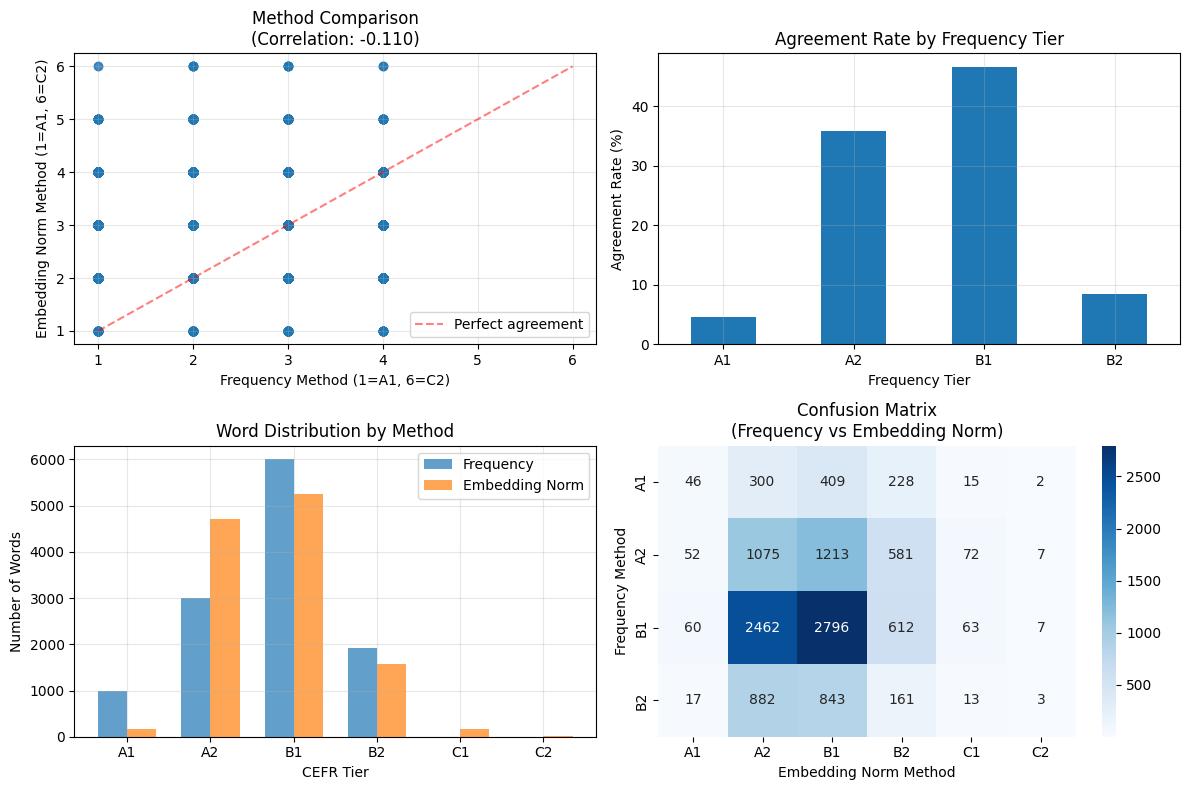


🔍 Examples of Disagreement:
de: Frequency=A1, Embedding=B1
que: Frequency=A1, Embedding=B1
la: Frequency=A1, Embedding=B1
y: Frequency=A1, Embedding=A2
a: Frequency=A1, Embedding=B1
en: Frequency=A1, Embedding=B1
su: Frequency=A1, Embedding=A2
no: Frequency=A1, Embedding=B1
el: Frequency=A1, Embedding=A2
se: Frequency=A1, Embedding=B1

ANALYSIS COMPLETE


In [11]:
# Quantitative Analysis
print("Performing quantitative analysis...")

# Create comparison DataFrame
comparison_data = []
for word in freq_lexicon.keys():
    if word in norm_lexicon:
        comparison_data.append({
            'word': word,
            'frequency_tier': freq_lexicon[word],
            'norm_tier': norm_lexicon[word],
            'same_classification': freq_lexicon[word] == norm_lexicon[word]
        })

comparison_df = pd.DataFrame(comparison_data)

# Calculate agreement statistics
total_words = len(comparison_df)
agreement_count = comparison_df['same_classification'].sum()
agreement_rate = agreement_count / total_words * 100

print(f"\n📊 Agreement Analysis:")
print(f"Total words compared: {total_words}")
print(f"Words with same classification: {agreement_count}")
print(f"Agreement rate: {agreement_rate:.1f}%")

# Create tier mapping for numerical analysis
tier_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
comparison_df['freq_numeric'] = comparison_df['frequency_tier'].map(tier_to_num)
comparison_df['norm_numeric'] = comparison_df['norm_tier'].map(tier_to_num)

# Calculate correlation
correlation = comparison_df['freq_numeric'].corr(comparison_df['norm_numeric'])
print(f"Correlation between methods: {correlation:.3f}")

# Create visualization
plt.figure(figsize=(12, 8))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(comparison_df['freq_numeric'], comparison_df['norm_numeric'], alpha=0.6)
plt.xlabel('Frequency Method (1=A1, 6=C2)')
plt.ylabel('Embedding Norm Method (1=A1, 6=C2)')
plt.title(f'Method Comparison\n(Correlation: {correlation:.3f})')
plt.plot([1, 6], [1, 6], 'r--', alpha=0.5, label='Perfect agreement')
plt.legend()
plt.grid(True, alpha=0.3)

# Agreement by tier
plt.subplot(2, 2, 2)
tier_agreement = comparison_df.groupby('frequency_tier')['same_classification'].mean() * 100
tier_agreement.plot(kind='bar')
plt.title('Agreement Rate by Frequency Tier')
plt.ylabel('Agreement Rate (%)')
plt.xlabel('Frequency Tier')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3)

# Distribution comparison - Fix the shape mismatch issue
plt.subplot(2, 2, 3)
freq_dist = comparison_df['frequency_tier'].value_counts().sort_index()
norm_dist = comparison_df['norm_tier'].value_counts().sort_index()

# Ensure both distributions have the same index (all possible tiers)
all_tiers = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
freq_dist = freq_dist.reindex(all_tiers, fill_value=0)
norm_dist = norm_dist.reindex(all_tiers, fill_value=0)

x = range(len(all_tiers))
width = 0.35
plt.bar([i - width/2 for i in x], freq_dist.values, width, label='Frequency', alpha=0.7)
plt.bar([i + width/2 for i in x], norm_dist.values, width, label='Embedding Norm', alpha=0.7)
plt.xlabel('CEFR Tier')
plt.ylabel('Number of Words')
plt.title('Word Distribution by Method')
plt.xticks(x, all_tiers)
plt.legend()
plt.grid(True, alpha=0.3)

# Confusion matrix
plt.subplot(2, 2, 4)
confusion_matrix = pd.crosstab(comparison_df['frequency_tier'], comparison_df['norm_tier'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix\n(Frequency vs Embedding Norm)')
plt.ylabel('Frequency Method')
plt.xlabel('Embedding Norm Method')

plt.tight_layout()
plt.show()

# Show disagreement examples
print("\n🔍 Examples of Disagreement:")
disagreements = comparison_df[~comparison_df['same_classification']].head(10)
for _, row in disagreements.iterrows():
    print(f"{row['word']}: Frequency={row['frequency_tier']}, Embedding={row['norm_tier']}")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

### 📈 Quantitative Analysis

**Correlation Analysis**: 
Create scatter plots comparing the two methods by plotting word ranks from the frequency method against normalized embedding norms. A strong positive correlation would indicate that both methods generally agree on word difficulty.

**Statistical Metrics**:
- Calculate agreement rate (percentage of words classified identically)
- Compute Pearson correlation coefficient between numerical tier assignments
- Generate confusion matrices to identify systematic differences

**Distribution Analysis**:
Compare how many words each method assigns to each CEFR level to identify potential biases.

### 🔍 Qualitative Observations

**Method Comparison Questions to Consider**:
1. Which method seemed more intuitive when viewing the colored sentences?
2. Were there surprising classifications where one method significantly differed from expectations?
3. Did the embedding norm method correctly identify difficult academic or technical words that might be frequent in specialized texts?
4. How did each method handle:
   - Short vs. long words?
   - Cognates and borrowed words?
   - Technical terminology?

**Topic-Specific Insights**:
- Did certain topics show better agreement between methods?
- Were there topic domains where one method was clearly more appropriate?

### 🎯 Conclusion

**Summary Space for Findings**:
*(Complete this section based on your observations)*

**Method Preference**:
Based on the quantitative metrics and qualitative observations, which method would be preferable for:
- Beginner language learners?
- Advanced learners?
- Specific domains (academic, conversational, technical)?

**Future Improvements**:
- How could these methods be combined for better performance?
- What additional features could enhance difficulty prediction?
- How might language-specific considerations improve the analysis?

**Practical Applications**:
Discuss how these findings could be implemented in real language learning applications, such as adaptive reading systems, vocabulary builders, or content difficulty assessment tools.

---

*This notebook demonstrates a novel approach to computational linguistics in language learning, combining established frequency-based methods with experimental embedding-based techniques to provide comprehensive word difficulty analysis.*